# Anchor-Reporter Selection

Tests the anchor-reporter hypothesis (notes/chat.txt) with an explicit entropy-based greedy algorithm:

**Phase 1 — Anchors** (insensitive, diverse):  
Greedily pick `l` nodes with **low drug-sensitivity** and **low pairwise MI** with each other.
Score at each step: `−sensitivity_j − β · mean_MI(j, selected_anchors)`

**Phase 2 — Reporters** (sensitive, informative):  
Given the `l` anchors, greedily add `k−l` nodes from the high-sensitivity pool  
that minimize `H(Drug | O_anchor ∪ O_reporter)` (plug-in entropy estimator).

**Key plot**: H(Drug | panel) vs number of nodes added — split into the anchor phase (entropy should stay high — anchors don't reveal drug info) and reporter phase (entropy drops quickly).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from typing import List, Tuple

DATA_FILE  = '../../data/drug-fixed-targets/N500/derived/states-1771875450457.csv'
N          = 500
NODE_COLS  = [f'node-{i}' for i in range(N)]

MAX_L      = 64   # max anchor nodes to sweep
MAX_K      = 64   # total feature budget for the anchor+reporter combined plot
BETA       = 1.0  # redundancy penalty weight in anchor scoring

# reporter selection via entropy is reliable only for small panels (2^k << n_samples)
# we cap at this size; beyond it the greedy order is still used but estimates are noisy
ENTROPY_RELIABLE_K = 8

In [2]:
states_df = pd.read_csv(DATA_FILE, index_col=0).reset_index()
states_df = states_df.rename(columns={'drug_name': 'Drug'})

# exclude initial_condition_idx == 0: that is the seed state X.
# all other ICs (1..9) are 0.99-correlated noisy copies X~ of the seed.
states_df = states_df[states_df['initial_condition_idx'] != 0]

print('drug values:', sorted(states_df['Drug'].unique()))
print('networks:   ', states_df['original_network_idx'].nunique())
print('total rows after dropping IC=0:', len(states_df))

control_df = states_df[states_df['Drug'] == 'control']
drug_df    = states_df[states_df['Drug'] != 'control']
print(f'control rows: {len(control_df)},  drug rows: {len(drug_df)}')

drug values: ['control', 'drug-1', 'drug-10', 'drug-2', 'drug-3', 'drug-4', 'drug-5', 'drug-6', 'drug-7', 'drug-8', 'drug-9']
networks:    50
total rows after dropping IC=0: 49500
control rows: 4500,  drug rows: 45000


## 1. Per-node sensitivity score

For each node $i$, sensitivity = mean $|s_i(\text{drug}) - s_i(\text{control})|$  
over all matched (network, IC, step, drug) pairs.  
High sensitivity → node changes a lot when any drug is applied.

sensitivity range: [0.2257, 0.3892]
mean: 0.2954,  median: 0.2954


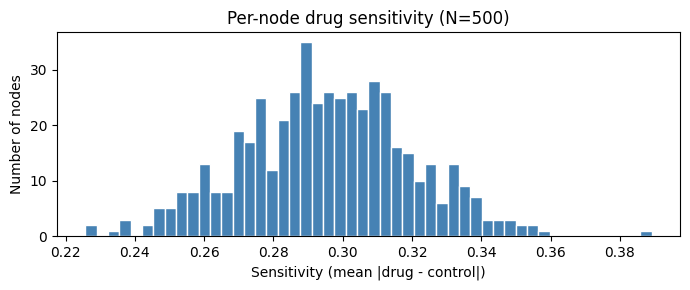

In [3]:
join_keys = ['original_network_idx', 'initial_condition_idx', 'step_num']

ctrl_slim = control_df[join_keys + NODE_COLS].rename(
  columns={c: f'{c}_ctrl' for c in NODE_COLS}
)
merged = drug_df.merge(ctrl_slim, on=join_keys)

drug_vals = merged[NODE_COLS].values
ctrl_vals = merged[[f'{c}_ctrl' for c in NODE_COLS]].values

sensitivity = (drug_vals ^ ctrl_vals).mean(axis=0)  # (N,)

print(f'sensitivity range: [{sensitivity.min():.4f}, {sensitivity.max():.4f}]')
print(f'mean: {sensitivity.mean():.4f},  median: {np.median(sensitivity):.4f}')

fig, ax = plt.subplots(figsize=(7, 3))
ax.hist(sensitivity, bins=50, color='steelblue', edgecolor='white')
ax.set_xlabel('Sensitivity (mean |drug - control|)')
ax.set_ylabel('Number of nodes')
ax.set_title('Per-node drug sensitivity (N=500)')
plt.tight_layout()
plt.show()

## 2. Pairwise MI matrix (vectorized)

For binary variables $X_i, X_j$:
$$I(X_i; X_j) = H(X_i) + H(X_j) - H(X_i, X_j)$$

The joint distribution is a 2×2 table.  
We compute all N² pairs at once using matrix multiplication: $P(X_i=1, X_j=1) = (X^\top X)/n$.

We use **control data** for this — we want anchors that are diverse in terms of the undrugged network's attractor structure.

In [9]:
def pairwise_mi_matrix(X: np.ndarray) -> np.ndarray:
  '''Compute pairwise mutual information matrix for N binary variables.

  X: (n_samples, N) binary {0,1} array
  Returns: (N, N) MI matrix in bits (symmetric, zero diagonal)
  '''
  n, N = X.shape
  X = X.astype(np.float64)

  p1  = X.mean(axis=0)             # (N,)  P(X_i = 1)
  p0  = 1 - p1
  p11 = (X.T @ X) / n              # (N,N) P(X_i=1, X_j=1)
  p10 = p1[:, None] - p11          # P(X_i=1, X_j=0)
  p01 = p1[None, :] - p11          # P(X_i=0, X_j=1)
  p00 = 1 - p1[:, None] - p1[None, :] + p11  # P(X_i=0, X_j=0)

  def h(p):
    return np.where(p > 1e-12, -p * np.log2(np.where(p > 1e-12, p, 1.0)), 0.0)

  H_joint    = h(p11) + h(p10) + h(p01) + h(p00)  # (N,N) joint entropy
  H_marginal = h(p1) + h(p0)                       # (N,)  marginal entropy

  MI = H_marginal[:, None] + H_marginal[None, :] - H_joint  # (N,N)
  np.fill_diagonal(MI, 0.0)
  return np.clip(MI, 0, None)


# compute from control data (all networks pooled)
X_ctrl_all = control_df[NODE_COLS].values.astype(np.float64)
MI_matrix  = pairwise_mi_matrix(X_ctrl_all)

print(f'MI matrix shape: {MI_matrix.shape}')
print(f'mean pairwise MI: {MI_matrix[np.triu_indices(N,1)].mean():.4f} bits')
print(f'max  pairwise MI: {MI_matrix[np.triu_indices(N,1)].max():.4f} bits')

MI matrix shape: (500, 500)
mean pairwise MI: 0.0075 bits
max  pairwise MI: 0.1539 bits


## 3. Entropy helpers

In [10]:
def plugin_entropy(counts: np.ndarray) -> float:
  counts = counts[counts > 0]
  n = counts.sum()
  if n == 0:
    return 0.0
  p = counts / n
  return float(-np.sum(p * np.log2(p)))


def conditional_entropy_y_given_panel(
  y: np.ndarray,
  panel_states: np.ndarray,
  n_classes: int,
) -> float:
  '''H(Y | panel) using the plug-in estimator.

  y: (n,) integer drug labels
  panel_states: (n,) integer encoding of the binary node states in the current panel
  '''
  n = len(y)
  _, state_idx = np.unique(panel_states, return_inverse=True)
  n_states = state_idx.max() + 1
  h = 0.0
  for si in range(n_states):
    mask = state_idx == si
    p_s = mask.sum() / n
    counts = np.bincount(y[mask], minlength=n_classes)
    h += p_s * plugin_entropy(counts)
  return h


# quick sanity: H(Y | X) = 0 when X == Y
y_t = np.array([0, 0, 1, 1])
assert conditional_entropy_y_given_panel(y_t, y_t, 2) < 1e-9
print('entropy helpers OK')

entropy helpers OK


## 4. Phase 1: Greedy anchor selection

At each step, score each candidate node:
$$\text{score}_j = -\underbrace{\text{sensitivity}_j}_{\text{insensitive to drug}} - \beta \cdot \underbrace{\frac{1}{|A|}\sum_{a \in A} I(O_j; O_a)}_{\text{redundant with anchors so far}}$$

Select the highest-scoring node (least sensitive, most diverse).

In [11]:
def greedy_anchor_select(
  sensitivity: np.ndarray,
  mi_matrix: np.ndarray,
  max_l: int,
  beta: float = BETA,
) -> List[int]:
  '''Greedily select max_l anchor nodes (insensitive + diverse).
  Returns list of node indices in selection order.
  '''
  n_nodes = len(sensitivity)
  in_anchor = np.zeros(n_nodes, dtype=bool)
  selected = []

  for step in range(max_l):
    if selected:
      # mean pairwise MI of each candidate with the current anchor set
      redundancy = mi_matrix[:, selected].mean(axis=1)  # (N,)
    else:
      redundancy = np.zeros(n_nodes)

    scores = -sensitivity - beta * redundancy
    scores[in_anchor] = -np.inf

    best = int(np.argmax(scores))
    selected.append(best)
    in_anchor[best] = True

  return selected

## 5. Phase 2: Greedy reporter selection

Given the anchor panel, greedily add reporter nodes minimizing $H(\text{Drug} \mid O_\text{panel})$.  
Reporters are drawn from the **high-sensitivity** nodes (upper half by sensitivity).

In [12]:
def greedy_reporter_select(
  X: np.ndarray,
  y_drug: np.ndarray,
  anchor_nodes: List[int],
  sensitivity: np.ndarray,
  n_reporters: int,
  n_drug_classes: int,
) -> Tuple[List[int], np.ndarray]:
  '''Greedy reporter selection minimising H(Drug | O_panel).

  Returns:
    reporter_nodes: list of selected node indices
    panel_states:   packed integer panel state array (anchor + reporter bits)
  '''
  n_nodes = X.shape[1]
  in_panel = np.zeros(n_nodes, dtype=bool)
  for a in anchor_nodes:
    in_panel[a] = True

  # build initial panel state from anchors
  panel_states = np.zeros(len(y_drug), dtype=np.int64)
  for bit, a in enumerate(anchor_nodes):
    panel_states = (panel_states << 1) | X[:, a].astype(np.int64)

  # reporter candidates: prefer high-sensitivity nodes
  reporter_candidates = np.argsort(-sensitivity)  # descending sensitivity

  selected_reporters = []
  for _ in range(n_reporters):
    best_h = np.inf
    best_node = -1

    for j in reporter_candidates:
      if in_panel[j]:
        continue
      new_states = (panel_states << 1) | X[:, j].astype(np.int64)
      h = conditional_entropy_y_given_panel(y_drug, new_states, n_drug_classes)
      if h < best_h:
        best_h = h
        best_node = j

    panel_states = (panel_states << 1) | X[:, best_node].astype(np.int64)
    in_panel[best_node] = True
    selected_reporters.append(best_node)

  return selected_reporters, panel_states

## 6. Run per-network analysis

For each network and each value of `l` (0, 1, 2, …, MAX_L):  
- Select `l` anchors  
- Compute H(Drug | O_anchor_panel) — should stay high (anchors don't reveal drug)  
- Select `MAX_L - l` reporters to fill the budget  
- Evaluate RF accuracy on the combined panel

In [14]:
from sklearn.model_selection import cross_val_score

def rf_accuracy(X_feat: np.ndarray, y: np.ndarray) -> float:
  clf = RandomForestClassifier(n_estimators=100, random_state=0)
  scores = cross_val_score(clf, X_feat, y, cv=3, scoring='accuracy')
  return scores.mean()


drug_label_col = 'Drug'
drug_names = sorted(states_df[states_df['Drug'] != 'control']['Drug'].unique())
drug_to_int = {d: i for i, d in enumerate(drug_names)}
n_drugs = len(drug_names)
print(f'drugs ({n_drugs}): {drug_names}')

# per-network sensitivity (averaged over all drugs vs control)
per_net_results = {}  # net_idx -> list of dicts

for net_idx in sorted(states_df['original_network_idx'].unique()):
  net_ctrl = control_df[control_df['original_network_idx'] == net_idx]
  net_drug = drug_df[drug_df['original_network_idx'] == net_idx]

  if len(net_ctrl) == 0 or len(net_drug) == 0:
    continue

  # -- per-network sensitivity --
  join_keys = ['initial_condition_idx', 'step_num']
  ctrl_slim = net_ctrl[join_keys + NODE_COLS].rename(
    columns={c: f'{c}_ctrl' for c in NODE_COLS}
  )
  net_merged = net_drug.merge(ctrl_slim, on=join_keys)
  dv = net_merged[NODE_COLS].values
  cv = net_merged[[f'{c}_ctrl' for c in NODE_COLS]].values
  net_sensitivity = (dv ^ cv).mean(axis=0)  # (N,)

  # -- greedy anchor selection --
  anchor_nodes_full = greedy_anchor_select(net_sensitivity, MI_matrix, max_l=MAX_L)

  # -- drug data for this network --
  X_drug = net_drug[NODE_COLS].values.astype(np.int64)
  y_drug = np.array([drug_to_int[d] for d in net_drug['Drug']])

  h_y_drug = plugin_entropy(np.bincount(y_drug, minlength=n_drugs))

  rows = []
  for l in range(0, MAX_L + 1):  # number of anchor nodes
    anchors = anchor_nodes_full[:l]

    # H(Drug | O_anchor)
    anchor_states = np.zeros(len(y_drug), dtype=np.int64)
    for bit, a in enumerate(anchors):
      anchor_states = (anchor_states << 1) | X_drug[:, a].astype(np.int64)
    h_drug_given_anchor = (
      conditional_entropy_y_given_panel(y_drug, anchor_states, n_drugs)
      if l > 0 else h_y_drug
    )

    rows.append({
      'net_idx': net_idx,
      'l': l,
      'h_drug_given_anchor': h_drug_given_anchor,
      'h_y_drug': h_y_drug,
    })

  per_net_results[net_idx] = rows
  print(f'network {net_idx:2d}: done', flush=True)

results_df = pd.DataFrame([row for rows in per_net_results.values() for row in rows])

drugs (10): ['drug-1', 'drug-10', 'drug-2', 'drug-3', 'drug-4', 'drug-5', 'drug-6', 'drug-7', 'drug-8', 'drug-9']
network  0: done
network  1: done
network  2: done
network  3: done
network  4: done
network  5: done
network  6: done
network  7: done
network  8: done
network  9: done
network 10: done
network 11: done
network 12: done
network 13: done
network 14: done
network 15: done
network 16: done
network 17: done
network 18: done
network 19: done
network 20: done
network 21: done
network 22: done
network 23: done
network 24: done
network 25: done
network 26: done
network 27: done
network 28: done
network 29: done
network 30: done
network 31: done
network 32: done
network 33: done
network 34: done
network 35: done
network 36: done
network 37: done
network 38: done
network 39: done
network 40: done
network 41: done
network 42: done
network 43: done
network 44: done
network 45: done
network 46: done
network 47: done
network 48: done
network 49: done


## 7. Plot: remaining H(Drug) vs number of anchor nodes

If the anchor-reporter hypothesis is correct, adding anchor (insensitive) nodes should **not** substantially reduce H(Drug | O_anchor) — anchors encode attractor/IC info, not drug info.

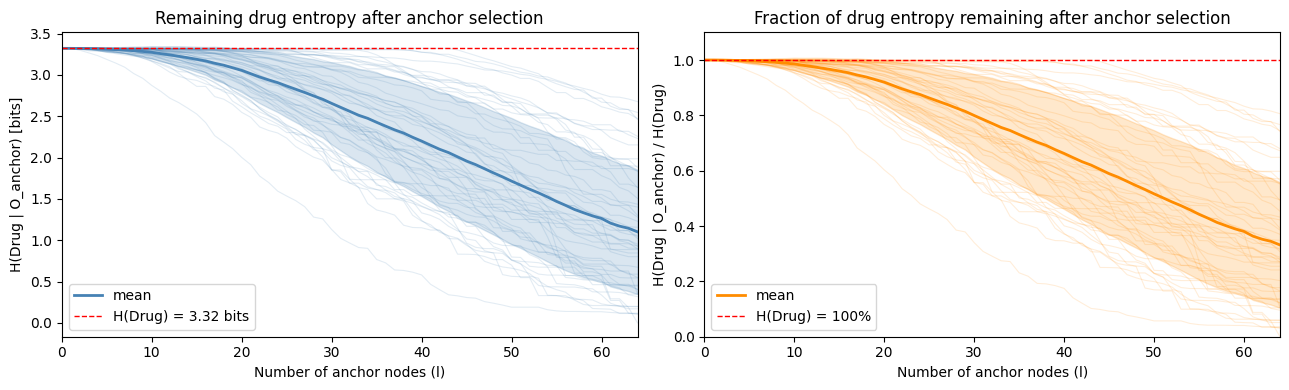

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# --- left: raw H(Drug | anchor panel) ---
ax = axes[0]
for net_idx, rows in per_net_results.items():
  ls = [r['l'] for r in rows]
  hs = [r['h_drug_given_anchor'] for r in rows]
  ax.plot(ls, hs, color='steelblue', alpha=0.15, linewidth=0.8)

mean_h = results_df.groupby('l')['h_drug_given_anchor'].mean()
std_h  = results_df.groupby('l')['h_drug_given_anchor'].std()
ax.plot(mean_h.index, mean_h.values, color='steelblue', linewidth=2, label='mean')
ax.fill_between(mean_h.index, mean_h - std_h, mean_h + std_h, alpha=0.2, color='steelblue')

mean_h_y = results_df.groupby('net_idx')['h_y_drug'].first().mean()
ax.axhline(mean_h_y, color='red', linestyle='--', linewidth=1, label=f'H(Drug) = {mean_h_y:.2f} bits')
ax.set_xlabel('Number of anchor nodes (l)')
ax.set_ylabel('H(Drug | O_anchor) [bits]')
ax.set_title('Remaining drug entropy after anchor selection')
ax.legend()
ax.set_xlim(0, MAX_L)

# --- right: fraction of H(Drug) remaining ---
ax = axes[1]
results_df['frac_remaining'] = results_df['h_drug_given_anchor'] / results_df['h_y_drug']
for net_idx, group in results_df.groupby('net_idx'):
  ax.plot(group['l'], group['frac_remaining'], color='darkorange', alpha=0.15, linewidth=0.8)

mean_frac = results_df.groupby('l')['frac_remaining'].mean()
std_frac  = results_df.groupby('l')['frac_remaining'].std()
ax.plot(mean_frac.index, mean_frac.values, color='darkorange', linewidth=2, label='mean')
ax.fill_between(mean_frac.index, mean_frac - std_frac, mean_frac + std_frac, alpha=0.2, color='darkorange')

ax.axhline(1.0, color='red', linestyle='--', linewidth=1, label='H(Drug) = 100%')
ax.set_xlabel('Number of anchor nodes (l)')
ax.set_ylabel('H(Drug | O_anchor) / H(Drug)')
ax.set_title('Fraction of drug entropy remaining after anchor selection')
ax.set_xlim(0, MAX_L)
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.savefig('../../plots/anchor-reporter-selection.png', dpi=150, bbox_inches='tight')
plt.show()

# interpretation:
# - if the curve stays flat near 1.0: anchors carry almost no drug info (good anchors)
# - if the curve drops quickly: the 'insensitive' nodes are not truly insensitive
#   (or the network doesn't have a clean anchor-reporter separation)

## 8. Compare anchor-reporter vs random selection (RF accuracy)

For a fixed total budget k, sweep l from 0 to k and compare RF accuracy.  
This tests whether the optimal split (some anchors + some reporters) outperforms pure reporters (l=0) or pure anchors (l=k).

In [17]:
TOTAL_K  = 16   # total feature budget for this comparison
L_VALUES = [l for l in [0, 1, 2, 4, 8, 12, 16] if l <= TOTAL_K]
N_TRIALS = 3    # RF trials per (net, l) for variance estimation

acc_rows = []

for net_idx in sorted(states_df['original_network_idx'].unique())[:10]:  # first 10 networks
  net_ctrl = control_df[control_df['original_network_idx'] == net_idx]
  net_drug = drug_df[drug_df['original_network_idx'] == net_idx]
  if len(net_ctrl) == 0 or len(net_drug) == 0:
    continue

  join_keys = ['initial_condition_idx', 'step_num']
  ctrl_slim = net_ctrl[join_keys + NODE_COLS].rename(
    columns={c: f'{c}_ctrl' for c in NODE_COLS}
  )
  net_merged = net_drug.merge(ctrl_slim, on=join_keys)
  net_sensitivity = (
    net_merged[NODE_COLS].values ^ net_merged[[f'{c}_ctrl' for c in NODE_COLS]].values
  ).mean(axis=0)

  anchor_nodes_full = greedy_anchor_select(net_sensitivity, MI_matrix, max_l=TOTAL_K)

  X_drug = net_drug[NODE_COLS].values.astype(np.int64)
  y_drug = np.array([drug_to_int[d] for d in net_drug['Drug']])

  for l in L_VALUES:
    anchors = anchor_nodes_full[:l]
    n_reporters = TOTAL_K - l

    # greedy reporters (entropy-based) — reliable for small panels
    reporters, _ = greedy_reporter_select(
      X_drug, y_drug, anchors, net_sensitivity, n_reporters, n_drugs
    )
    panel = anchors + reporters
    X_panel = X_drug[:, panel]

    for trial in range(N_TRIALS):
      acc = rf_accuracy(X_panel, y_drug)
      acc_rows.append({'net_idx': net_idx, 'l': l, 'k': TOTAL_K, 'trial': trial, 'accuracy': acc, 'method': 'anchor+reporter'})

  # random selection baseline
  for trial in range(N_TRIALS):
    rng_nodes = np.random.choice(N, TOTAL_K, replace=False)
    acc = rf_accuracy(X_drug[:, rng_nodes], y_drug)
    acc_rows.append({'net_idx': net_idx, 'l': -1, 'k': TOTAL_K, 'trial': trial, 'accuracy': acc, 'method': 'random'})

  print(f'network {net_idx:2d}: done', flush=True)

acc_df = pd.DataFrame(acc_rows)

network  0: done
network  1: done
network  2: done
network  3: done
network  4: done
network  5: done
network  6: done
network  7: done
network  8: done
network  9: done


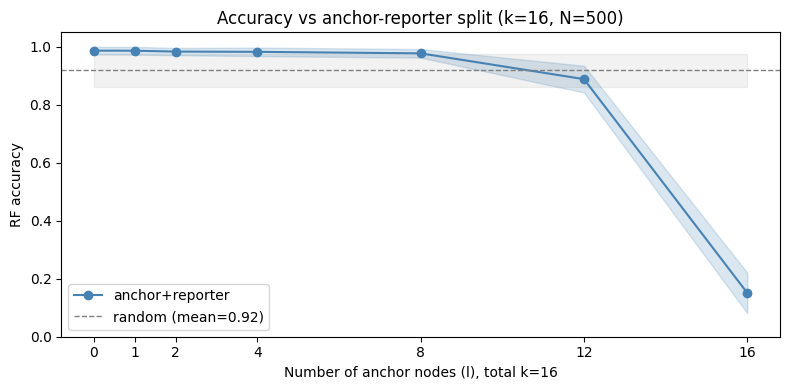

Optimal l: 0 with accuracy: 0.987


In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

ar_df = acc_df[acc_df['method'] == 'anchor+reporter']
mean_acc = ar_df.groupby('l')['accuracy'].mean()
std_acc  = ar_df.groupby('l')['accuracy'].std()
ax.plot(mean_acc.index, mean_acc.values, 'o-', color='steelblue', label='anchor+reporter')
ax.fill_between(mean_acc.index, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2, color='steelblue')

rnd_mean = acc_df[acc_df['method'] == 'random']['accuracy'].mean()
rnd_std  = acc_df[acc_df['method'] == 'random']['accuracy'].std()
ax.axhline(rnd_mean, color='gray', linestyle='--', linewidth=1, label=f'random (mean={rnd_mean:.2f})')
ax.fill_between([0, max(L_VALUES)], rnd_mean - rnd_std, rnd_mean + rnd_std, alpha=0.1, color='gray')

ax.set_xlabel(f'Number of anchor nodes (l), total k={TOTAL_K}')
ax.set_ylabel('RF accuracy')
ax.set_title(f'Accuracy vs anchor-reporter split (k={TOTAL_K}, N=500)')
ax.set_xticks(L_VALUES)
ax.legend()
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

print('Optimal l:', mean_acc.idxmax(), 'with accuracy:', mean_acc.max().round(3))